In [1]:
"""
    Get cleaned data
"""

import numpy as np

dataset = np.load('./datasets/Power_per_bandRNN.npy')
labels = np.load('./datasets/labels.npy')
print(dataset.shape)
print(labels.shape)

(889, 60, 20)
(889,)


In [2]:
"""
    Split dataset
"""

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
shuf_dataset, shuf_labels = shuffle(dataset, labels)
X_train, X_test, y_train, y_test = train_test_split(shuf_dataset, shuf_labels, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print("Train set size: {}, Val set size: {}, Test set size: {}".format(len(X_train), len(X_val), len(X_test)))
print(y_train.shape)
print(X_train.shape)

Train set size: 622, Val set size: 134, Test set size: 133
(622,)
(622, 60, 20)


In [10]:
"""
    Model and train
"""

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_path = './models/'
json_name = 'RNN_Power.json'
weight_name = 'RNN_Power_tmp.h5'

batch_size = 16
epochs = 128
num_classes = 2

print("Constructing MLP Model: ...", end='')
model = Sequential()
model.add(LSTM(32, return_sequences=False, input_shape=(X_train.shape[1:])))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
print(" Complete.")

print("Compiling MLP Model: ...", end='')
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
print(" Complete.")

earlyStop = EarlyStopping(monitor='val_loss', patience=32, mode='min')
mcp_save = ModelCheckpoint(filepath=model_path+weight_name, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

print("Fitting MLP Model: ...")
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[earlyStop, mcp_save, reduce_lr_loss], validation_data=(X_val, y_val), shuffle=True)
print("Complete.")

Constructing MLP Model: ... Complete.
Compiling MLP Model: ... Complete.
Fitting MLP Model: ...
Train on 622 samples, validate on 134 samples
Epoch 1/128
622/622 [==============================] - 4s 6ms/step - loss: 0.5839 - acc: 0.6881 - val_loss: 0.4465 - val_acc: 0.7985
Epoch 2/128
622/622 [==============================] - 2s 4ms/step - loss: 0.4278 - acc: 0.8167 - val_loss: 0.3730 - val_acc: 0.8284
Epoch 3/128
622/622 [==============================] - 2s 4ms/step - loss: 0.3486 - acc: 0.8617 - val_loss: 0.3623 - val_acc: 0.8209
Epoch 4/128
622/622 [==============================] - 2s 4ms/step - loss: 0.3169 - acc: 0.8698 - val_loss: 0.4236 - val_acc: 0.8358
Epoch 5/128
622/622 [==============================] - 2s 4ms/step - loss: 0.2787 - acc: 0.8810 - val_loss: 0.3037 - val_acc: 0.8657
Epoch 6/128
622/622 [==============================] - 2s 4ms/step - loss: 0.2750 - acc: 0.8891 - val_loss: 0.4180 - val_acc: 0.8209
Epoch 7/128
622/622 [==============================] - 2s 4m

In [11]:
"""
    Save the model
"""

model_path = './models/'
json_name = 'RNN_Power.json'
weight_name = 'RNN_Power.h5'

model_json = model.to_json()
with open(model_path+json_name, 'w') as json_file:
    json_file.write(model_json)
#model.save_weights(model_path+weight_name)

133/133 [==============================] - 0s 391us/step

Final test acc: 93.23%


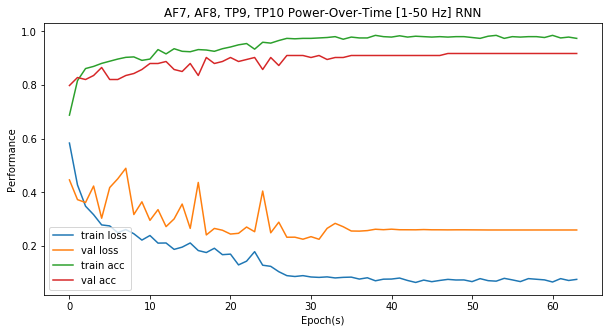

In [14]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'RNN_Power_2to1.png'

fig = plt.figure(figsize=(10,5))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
#plt.ylim((0.05,1.05))
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Power-Over-Time [1-50 Hz] RNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')
test_scores = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

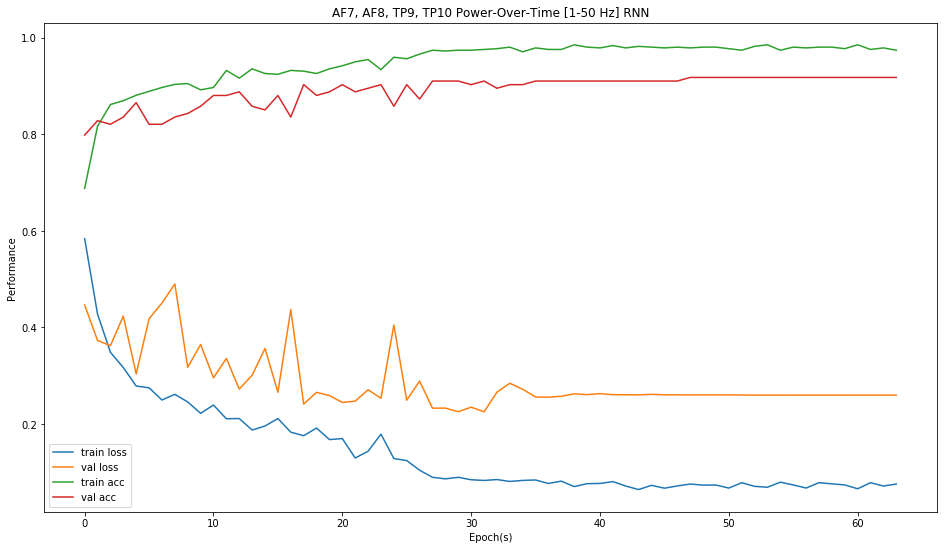

In [15]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'RNN_Power_16to9.png'

fig = plt.figure(figsize=(16,9))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.legend(loc='lower left')
plt.title('AF7, AF8, TP9, TP10 Power-Over-Time [1-50 Hz] RNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')

In [16]:
"""
    Try fetching the model
"""

from keras.models import model_from_json

model_path = './models/'
json_name = 'RNN_Power.json'
weight_name = 'RNN_Power.h5'

json_file = open(model_path+json_name)
loaded_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights(model_path+weight_name)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

loaded_test_score = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (loaded_model.metrics_names[1], loaded_test_score[1]*100))

133/133 [==============================] - 0s 3ms/step

Final test acc: 93.23%
